<a href="https://colab.research.google.com/github/mrmamadi/regression10/blob/checking_data/EDA_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Import data
import pandas as pd
from datetime import datetime

train_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/EDSA/2 Machine Learning/1 Regression/4 Predict/Data Original/Train.csv')
test_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/EDSA/2 Machine Learning/1 Regression/4 Predict/Data Original/Test.csv')
rider_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/EDSA/2 Machine Learning/1 Regression/4 Predict/Data Original/Riders.csv')




# First check on data (Info)

Calling ```.info()``` reveals:
- train_data
  - 21201 entries 29 columns
    - 10 string columns
      - <font color=red> expected all time columns to be intergers </font> **action required**
        - because values contain text (AM and PM)
        - <font color=red> convert columns to seconds </font> because response variable given in seconds
    - Categorical columns
      - Order number 
        - order numbering does not make sense (so can't use it to make time series plots)
      - User ID
        - Categorical column
        - Not sure how to use this
      - <font color=red>Vehicle type</font>
        - All motocycles so we can <font color=red> delete this column </font>
      - Rider ID
        - Categorical column 
        - <font color=red> delete because we feel that average rating is the important information </font>
          - has high number of unique values
      - Business or Personal
        - Convert to 0 or 1 (1 for Business)

    - 13 integer64 columns
    - 6 float64 columns
      - Temperature and precipitation have missing values (4366/20.6% and 20649/97.4% respectively)
      - **action required**
        - <font color=red> Precipitation column </font>
          - there are no zero rain precipitation values, 
            - don't think it rains 365 days a year in East Africa
            - so assumption is that empty cells are meant for instances where it wasn't raining
            - <font color=red> filled with zeros </font>
            - also create new column that categorizes into ordinal variable of precipitation
              - 0 (<30)
              - 1 (30 <= precitpation < 70)
              - 2 (precitpation >= 70)
        - <font color=red> Temperature columns </font>
          - mean and median are pretty similar and there doesn't seem to be any outliers so choice doesn't matter (distribution can be approximated as normal)
            - all empty entries will be <font color=red>filled with median </font> of hour of the day
              - because temperature taken very 3 hours of day
              - created a dataframe for average temperature for every our

- test_data
  - 7068 entries 25 columns
    - 10 string columns
    - 10 int64 columns
    - 6 float columns
______
Discrepency in number of integer columns 
- 1 was expect but 4 found **action required**
  - missing columns in test data
    - <font color='red'> Arrival at Destination - Day of Month', 'Arrival at Destination - Weekday (Mo = 1)', 'Arrival at Destination - Time', 'Time from Pickup to Arrival' </font>
    - was only expecting 'Time from Pickup to Arrival' to be missing
    - I think we should <font color='red'> delete these columns </font> becuase it will be difficult combine them without the year information 
      - we are also not going to use them to fit the data
______

Looking through data it appears that some columns are very similar **action required**
- train data
  - Placement and confirmation day of month (same as Weekday info)
    - only 2 columns are have different days (1 and 2 days)
  - Pickup and Arrival at Pickup - Day of Month (same as Weekday info)
    - columns are identical

- test data
  - Placement and confirmation day of month (same as Weekday info)
    - columns are identical
  - Pickup and Arrival at Pickup - Day of Month (same as Weekday info)
    - columns are identical

In general I would argue that <font color='blue'>everything tends to happen in 1 day </font>. It would suggest we only use the day information in converting  time to seconds and thus <font color='red'> delete the placement, confirmation, arrival pickup and arrival destination day information information</font>. 
  - We should consider deleting placement time column becuase I don't think it add any information.
____

Convert <font color=red>time info to seconds </font> (match with the response variable) **attention required**
Check time columns (arrival and confirmation times)
  - keep time columns and delete depending on model behaviour (add column for time difference between confirmation and pickup)
    - It could give insights about the place it's being picked up at
      - e.g. Like remote locations would take longer to get to


___






In [0]:
train_data.info()
print('\n')
rider_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21201 entries, 0 to 21200
Data columns (total 29 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Order No                                   21201 non-null  object 
 1   User Id                                    21201 non-null  object 
 2   Vehicle Type                               21201 non-null  object 
 3   Platform Type                              21201 non-null  int64  
 4   Personal or Business                       21201 non-null  object 
 5   Placement - Day of Month                   21201 non-null  int64  
 6   Placement - Weekday (Mo = 1)               21201 non-null  int64  
 7   Placement - Time                           21201 non-null  object 
 8   Confirmation - Day of Month                21201 non-null  int64  
 9   Confirmation - Weekday (Mo = 1)            21201 non-null  int64  
 10  Confirmation - Time   

In [0]:
#@title Check user id and rider_id
print(f"different user_id's train data: {train_data['User Id'].nunique()} from {len(train_data)}")
print(f"different user_id's test data: {test_data['User Id'].nunique()} from {len(test_data)}")
print(f"different user_id's test data: {rider_data['Rider Id'].nunique()} from {len(rider_data)}")


different user_id's train data: 3186 from 21201
different user_id's test data: 1617 from 7068
different user_id's test data: 960 from 960


In [0]:
#@title Drop Vehicle Type and convert Business/Personal column

train_data.drop(columns= ['Vehicle Type'], inplace=True)
test_data.drop(columns= ['Vehicle Type'], inplace=True)

train_data['Personal or Business'] = train_data['Personal or Business'].apply(lambda x: 1 if x=='Business' else 0)
test_data['Personal or Business'] = test_data['Personal or Business'].apply(lambda x: 1 if x=='Business' else 0)

print("Vehicle Type removed and Business changed to categorical")

Vehicle Type removed and Business changed to categorical


In [0]:
#@title  Confirm that columns are similar (And that everything happens in the same day)

def print_row(df, column1, column2, additional_text = ""):
  """
  function prints out number of rows containing different values between 
  column1 and column2 of dataframe df
  """
  diff_rows = (df[df[column1] != df[column2]]).shape[0]
  print(f"[{column1}] vs [{column2}] has {diff_rows} different entries {additional_text}")

# Placement vs Confirmation columns
print("_"*110+'\n')
print(" "*int((110)/2-16)+"Placement vs Confirmation columns")
print("_"*110)

print_row(
    train_data, 
    'Placement - Day of Month', 
    'Confirmation - Day of Month', 
    'in train data')

print_row(
    test_data, 
    'Placement - Day of Month', 
    'Confirmation - Day of Month', 
    'in test data')

print_row(
    train_data, 
    'Placement - Weekday (Mo = 1)', 
    'Confirmation - Weekday (Mo = 1)', 
    'in train data')

print_row(
    test_data, 
    'Placement - Weekday (Mo = 1)', 
    'Confirmation - Weekday (Mo = 1)', 
    'in test data')

print(f"\n rows that has different confirmation and placement \n {train_data[train_data['Placement - Day of Month']!=train_data['Confirmation - Day of Month']]['Order No']}")


#Confirmation vs Arrival at pickup columns
print("_"*110+'\n')
print(" "*int((110)/2-16)+"Confirmation vs Arrival at pickup columns")
print("_"*110)

print_row(
    train_data, 
    'Arrival at Pickup - Day of Month', 
    'Confirmation - Day of Month', 
    'in train data')

print_row(
    test_data, 
    'Arrival at Pickup - Day of Month', 
    'Confirmation - Day of Month', 
    'in test data')

print_row(
    train_data, 
    'Arrival at Pickup - Weekday (Mo = 1)', 
    'Confirmation - Weekday (Mo = 1)', 
    'in train data')

print_row(
    test_data, 
    'Arrival at Pickup - Weekday (Mo = 1)', 
    'Confirmation - Weekday (Mo = 1)', 
    'in test data')


# Pickup vs Arrival at pickup columns
print("_"*110+'\n')
print(" "*int((110)/2-16)+"Pickup vs Arrival at pickup columns")
print("_"*110)
print_row(
    train_data, 
    'Pickup - Day of Month', 
    'Arrival at Pickup - Day of Month', 
    'in train data')

print_row(
    test_data, 
    'Pickup - Day of Month', 
    'Arrival at Pickup - Day of Month', 
    'in test data')

print_row(
    train_data, 
    'Pickup - Weekday (Mo = 1)', 
    'Arrival at Pickup - Weekday (Mo = 1)', 
    'in train data')

print_row(
    test_data, 
    'Pickup - Weekday (Mo = 1)', 
    'Arrival at Pickup - Weekday (Mo = 1)', 
    'in test data')


# Pickup vs Arrival at Destination columns
print("_"*110+'\n')
print(" "*int((110)/2-16)+"Pickup vs Arrival at pickup columns")
print("_"*110)

print_row(
    train_data, 
    'Arrival at Destination - Day of Month', 
    'Pickup - Day of Month', 
    'in train data')

print_row(
    train_data, 
    'Arrival at Destination - Weekday (Mo = 1)', 
    'Pickup - Weekday (Mo = 1)', 
    'in train data')

______________________________________________________________________________________________________________

                                       Placement vs Confirmation columns
______________________________________________________________________________________________________________
[Placement - Day of Month] vs [Confirmation - Day of Month] has 2 different entries in train data
[Placement - Day of Month] vs [Confirmation - Day of Month] has 0 different entries in test data
[Placement - Weekday (Mo = 1)] vs [Confirmation - Weekday (Mo = 1)] has 2 different entries in train data
[Placement - Weekday (Mo = 1)] vs [Confirmation - Weekday (Mo = 1)] has 0 different entries in test data

 rows that has different confirmation and placement 
 4024    Order_No_2800
9804    Order_No_3530
Name: Order No, dtype: object
______________________________________________________________________________________________________________

                                       Confirmation vs Ar

In [0]:
#@title Drop those 2 rows

train_data = train_data[train_data['Placement - Day of Month']==train_data['Confirmation - Day of Month']]
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21199 entries, 0 to 21200
Data columns (total 28 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Order No                                   21199 non-null  object 
 1   User Id                                    21199 non-null  object 
 2   Platform Type                              21199 non-null  int64  
 3   Personal or Business                       21199 non-null  int64  
 4   Placement - Day of Month                   21199 non-null  int64  
 5   Placement - Weekday (Mo = 1)               21199 non-null  int64  
 6   Placement - Time                           21199 non-null  object 
 7   Confirmation - Day of Month                21199 non-null  int64  
 8   Confirmation - Weekday (Mo = 1)            21199 non-null  int64  
 9   Confirmation - Time                        21199 non-null  object 
 10  Arrival at Pickup - Da

## Handle missing values in Temperature and precipitation columns



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


minimum precipitation measured is 0.1mm


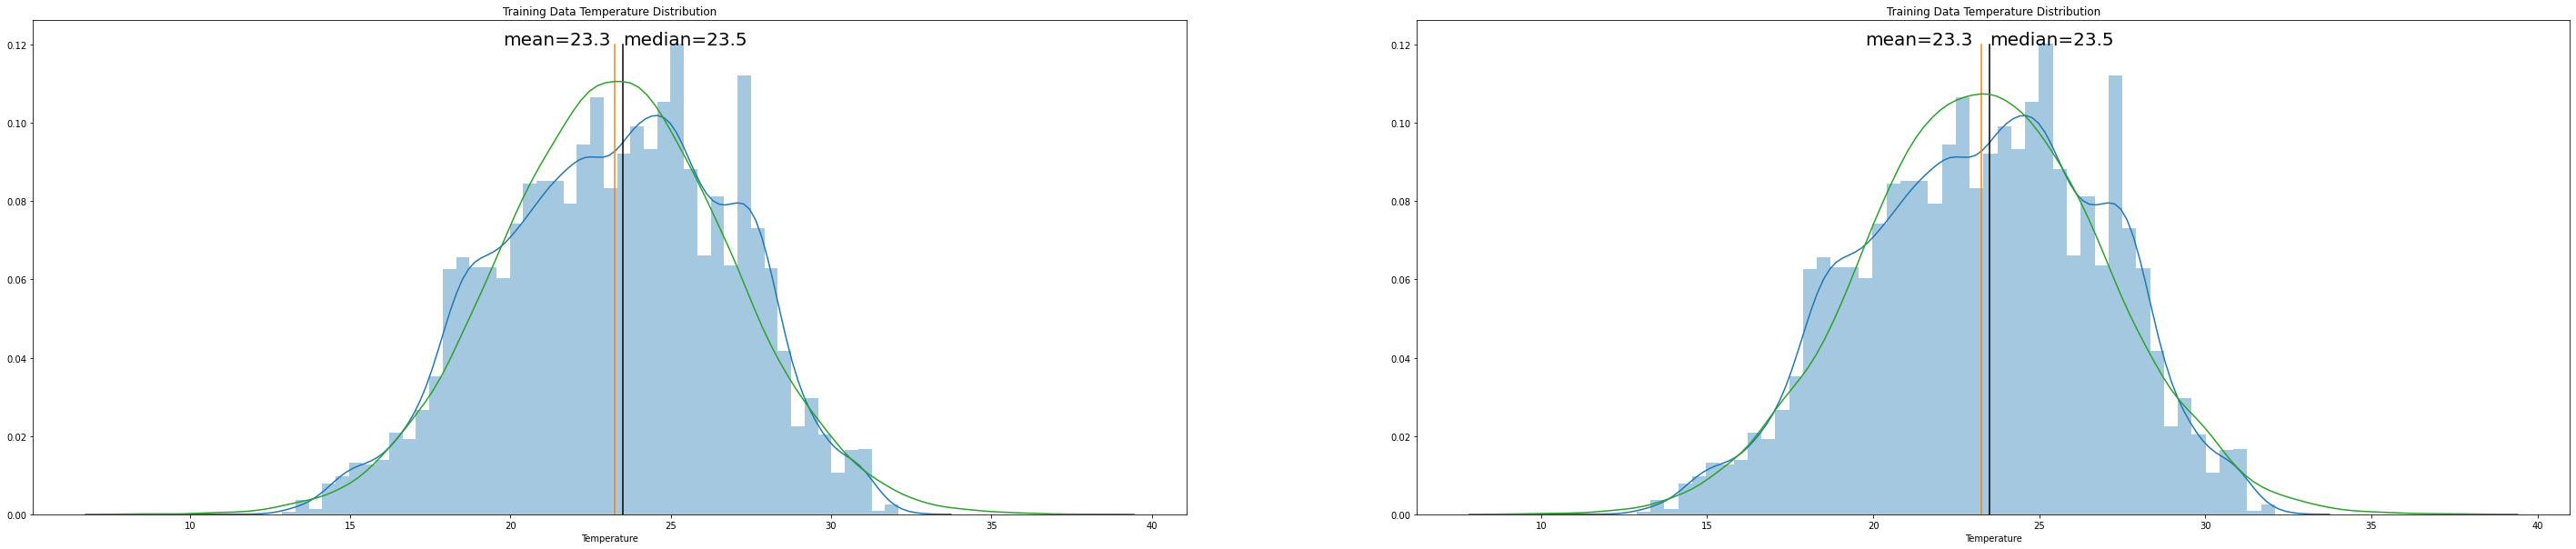

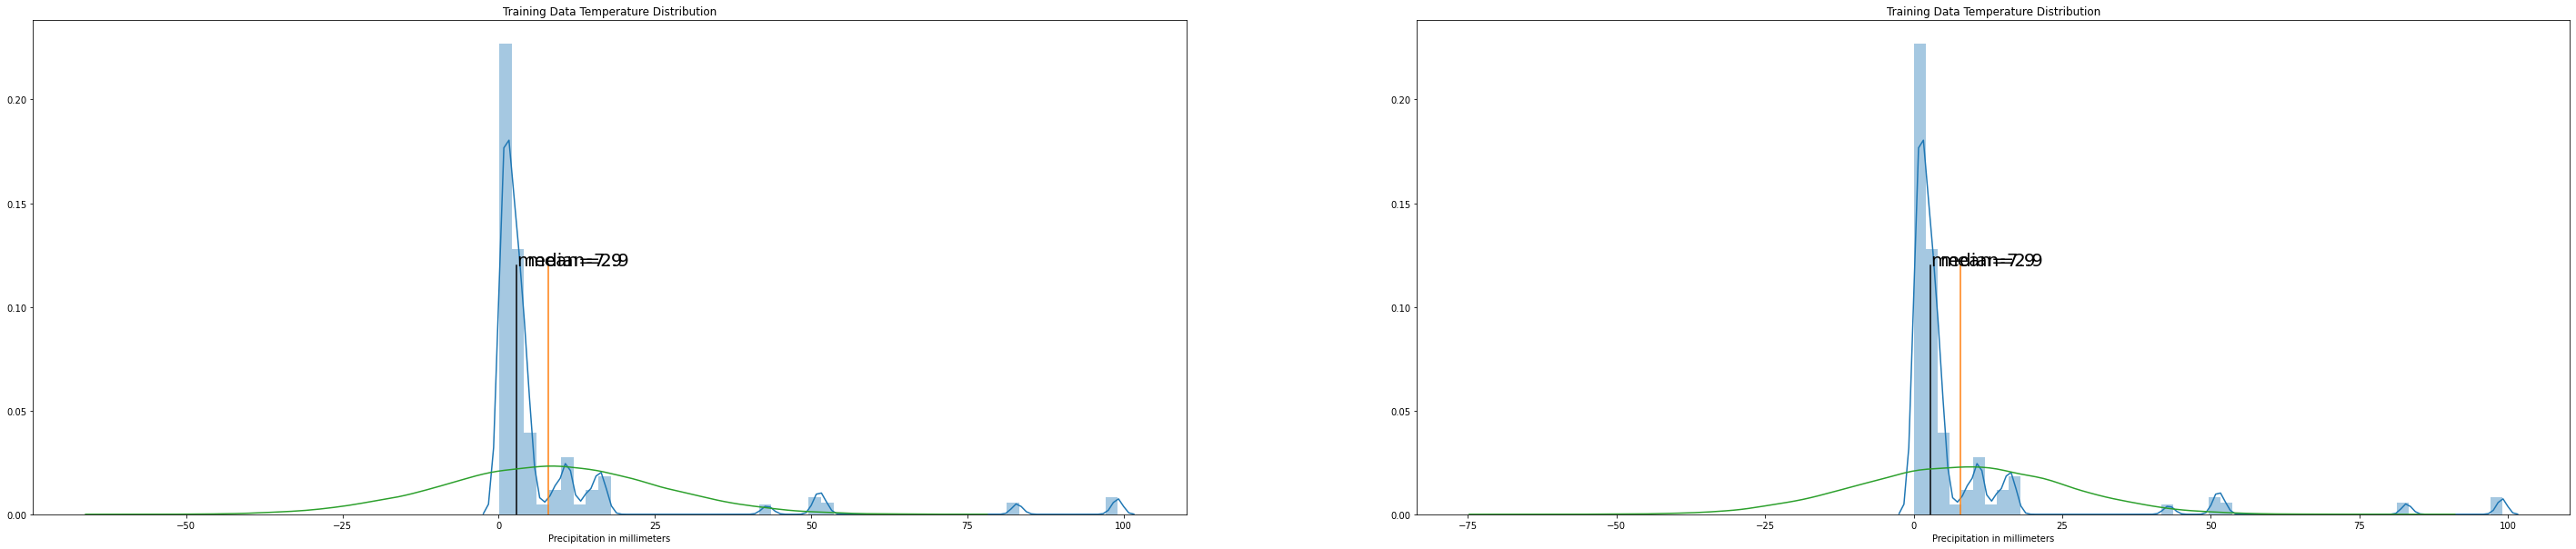

In [0]:
# @title Check Precipitation and temperature columns
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
import numpy as np

rain = train_data["Precipitation in millimeters"]
print(f"minimum precipitation measured is {rain.min()}mm")

rcParams['figure.figsize'] = 50, 10

f, axes = plt.subplots(1, 2)

temps = train_data['Temperature']
sns.distplot(temps, ax=axes[0])
axes[0].plot([temps.mean(), temps.mean()],[0,0.12])
axes[0].plot([temps.median(), temps.median()],[0,0.12], color='k')
axes[0].text(x=temps.median(),y=.12, s=f'median={temps.median()}', fontsize=20)
axes[0].text(temps.mean()-3.5,.12, f'mean={round(temps.mean(),1)}', fontsize=20)
sns.kdeplot(np.random.normal(temps.mean(), temps.std(), temps.shape), ax=axes[0])
axes[0].set_title('Training Data Temperature Distribution')

temps = train_data['Temperature']
sns.distplot(temps, ax=axes[1])
axes[1].plot([temps.mean(), temps.mean()],[0,0.12])
axes[1].plot([temps.median(), temps.median()],[0,0.12], color='k')
axes[1].text(temps.median(),.12, f'median={temps.median()}', fontsize=20)
axes[1].text(temps.mean()-3.5,.12, f'mean={round(temps.mean(),1)}', fontsize=20)
sns.kdeplot(np.random.normal(temps.mean(), temps.std(), temps.shape), ax=axes[1])
axes[1].set_title('Training Data Temperature Distribution')
plt.show()

f, axes = plt.subplots(1, 2)

temps = train_data['Precipitation in millimeters']
sns.distplot(temps, ax=axes[0])
axes[0].plot([temps.mean(), temps.mean()],[0,0.12])
axes[0].plot([temps.median(), temps.median()],[0,0.12], color='k')
axes[0].text(x=temps.median(),y=.12, s=f'median={temps.median()}', fontsize=20)
axes[0].text(temps.mean()-3.5,.12, f'mean={round(temps.mean(),1)}', fontsize=20)
sns.kdeplot(np.random.normal(temps.mean(), temps.std(), temps.shape), ax=axes[0])
axes[0].set_title('Training Data Temperature Distribution')

temps = train_data['Precipitation in millimeters']
sns.distplot(temps, ax=axes[1])
axes[1].plot([temps.mean(), temps.mean()],[0,0.12])
axes[1].plot([temps.median(), temps.median()],[0,0.12], color='k')
axes[1].text(temps.median(),.12, f'median={temps.median()}', fontsize=20)
axes[1].text(temps.mean()-3.5,.12, f'mean={round(temps.mean(),1)}', fontsize=20)
sns.kdeplot(np.random.normal(temps.mean(), temps.std(), temps.shape), ax=axes[1])
axes[1].set_title('Training Data Temperature Distribution')
plt.show()

In [0]:
#@title Fill nulls in Precipitation, Temperature columns, create Precipitation Category column
from sklearn.impute import SimpleImputer
from itertools import compress

def impute_temperature(df_imputed, original_train_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/EDSA/2 Machine Learning/1 Regression/4 Predict/Data Original/Train.csv')):
  df = df_imputed.copy()
  train_data = original_train_data.copy()

  train_data['temp_plcmnt_time'] = pd.to_datetime(train_data['Placement - Time']).dt.strftime('%H')
  avg_temps = train_data.groupby(['temp_plcmnt_time'])['Temperature'].mean().to_frame().reset_index()

  df['temp_plcmnt_time'] = pd.to_datetime(df['Placement - Time']).dt.strftime('%H')
  temp = df.merge(avg_temps, on='temp_plcmnt_time', how='left', suffixes=('', '2'))
  df['Temperature'] = temp['Temperature'].fillna(temp['Temperature2'])
  df.drop(columns='temp_plcmnt_time')

  return df['Temperature']



#Precipitation
rain_imputer = SimpleImputer(strategy='constant', fill_value=0)
rain_imputer.fit(train_data['Precipitation in millimeters'].values.reshape(-1,1))

train_data['Precipitation in millimeters']= rain_imputer.transform(
                train_data['Precipitation in millimeters'].values.reshape(-1,1))
test_data['Precipitation in millimeters']= rain_imputer.transform(
                test_data['Precipitation in millimeters'].values.reshape(-1,1))


#Create Precipitation Column
get_cat = lambda x: list(compress([0,1,2],[x<30, x>=30 and x<70, x>70]))[0]
train_data['Precipitation Category'] = train_data['Precipitation in millimeters'].apply(get_cat)
test_data['Precipitation Category'] = test_data['Precipitation in millimeters'].apply(get_cat)

#Temperatures
train_data['Temperature'] = impute_temperature(train_data)
test_data['Temperature'] =  impute_temperature(test_data)

# f, axes = plt.subplots(1, 2)

temps = train_data['Temperature']
sns.distplot(temps, ax=axes[0])
axes[0].plot([temps.mean(), temps.mean()],[0,0.12])
axes[0].plot([temps.median(), temps.median()],[0,0.12], color='k')
axes[0].text(x=temps.median(),y=.12, s=f'median={temps.median()}', fontsize=20)
axes[0].text(temps.mean()-3.5,.12, f'mean={round(temps.mean(),1)}', fontsize=20)
sns.kdeplot(np.random.normal(temps.mean(), temps.std(), temps.shape), ax=axes[0])
axes[0].set_title('Training Data Temperature Distribution')

temps = train_data['Temperature']
sns.distplot(temps, ax=axes[1])
axes[1].plot([temps.mean(), temps.mean()],[0,0.12])
axes[1].plot([temps.median(), temps.median()],[0,0.12], color='k')
axes[1].text(temps.median(),.12, f'median={temps.median()}', fontsize=20)
axes[1].text(temps.mean()-3.5,.12, f'mean={round(temps.mean(),1)}', fontsize=20)
sns.kdeplot(np.random.normal(temps.mean(), temps.std(), temps.shape), ax=axes[1])
axes[1].set_title('Training Data Temperature Distribution')
plt.show()

## Look at time information

In [0]:
#@title Convert time information to seconds

def convert_to_time(df):
  '''Changes all columns containing "Time" in title to time objects
      Midnight day of pickup is the zero point'''
  pick_up_day = 'Pickup - Day of Month'
  for column in df.columns:
    if ("Time" in column) and ("Pickup to Arrival" not in column):
      try:
        curr_day_col = column[:-4] + "Day of Month"
        df[column] = pd.to_datetime(df[column], format='%I:%M:%S %p').dt.time
        if ('Placement' in column) or ('Confirmation' in column):
          df[column] = df.apply(
              lambda t: (t[curr_day_col]-t[pick_up_day])*24*60*60 - (24*60*60 - (t[column].hour * 60 + t[column].minute) * 60 + t[column].second), 
              axis=1
              )
        else:
          df[column] = df.apply(
              lambda t: (t[curr_day_col]-t[pick_up_day])*24*60*60 + (t[column].hour * 60 + t[column].minute) * 60 + t[column].second, 
              axis=1
              )
      except ValueError:
        print(f"'{column}' column is already a time object'")
  return df

convert_to_time(train_data)
convert_to_time(test_data)

# ((
#   train_data['Arrival at Destination - Time']-train_data['Pickup - Time']
#   ) == pd.read_csv(
#     '/content/drive/My Drive/Colab Notebooks/EDSA/2 Machine Learning/1 Regression/4 Predict/Data Original/Train.csv'
#     )['Time from Pickup to Arrival']
# ).value_counts()

Order No       User Id  ...      Rider Id  Precipitation Category
0     Order_No_19248  User_Id_3355  ...  Rider_Id_192                       0
1     Order_No_12736  User_Id_3647  ...  Rider_Id_868                       0
2       Order_No_768  User_Id_2154  ...   Rider_Id_26                       0
3     Order_No_15332  User_Id_2910  ...  Rider_Id_685                       0
4     Order_No_21373  User_Id_1205  ...  Rider_Id_858                       0
...              ...           ...  ...           ...                     ...
7063   Order_No_3612  User_Id_2587  ...  Rider_Id_362                       0
7064   Order_No_7657  User_Id_3547  ...  Rider_Id_669                       0
7065   Order_No_1969   User_Id_136  ...  Rider_Id_379                       0
7066  Order_No_10591  User_Id_1979  ...  Rider_Id_474                       0
7067   Order_No_1603  User_Id_1721  ...   Rider_Id_76                       0

[7068 rows x 25 columns]

In [0]:
#@title Add Time from Confirmation to Pickup Column
train_data['Time from Confirmation to Pickup'] = train_data['Pickup - Time']-train_data['Confirmation - Time']
test_data['Time from Confirmation to Pickup'] = test_data['Pickup - Time']-test_data['Confirmation - Time']

In [0]:
#@title Check missing integer columns (missing from test data)

#get column names
train_cols = train_data.columns
test_cols = test_data.columns

#compare column names
missing_columns = [train_column for train_column in train_cols if (train_column not in test_cols)]
print(f"following columns are missing from test set: {missing_columns}")

following columns are missing from test set: ['Arrival at Destination - Day of Month', 'Arrival at Destination - Weekday (Mo = 1)', 'Arrival at Destination - Time', 'Time from Pickup to Arrival']


In [0]:
#@title Remove placement, confirmation, arrival pickup and arrival destination day information information. 
train_data.drop(
    columns=[
             'Placement - Day of Month', 
             'Placement - Weekday (Mo = 1)',
             'Confirmation - Day of Month',
             'Confirmation - Weekday (Mo = 1)',
             'Arrival at Pickup - Day of Month', 
             'Arrival at Pickup - Weekday (Mo = 1)',
             'Pickup - Day of Month',
             'Pickup - Weekday (Mo = 1)',
             'Arrival at Destination - Day of Month',
             'Arrival at Destination - Weekday (Mo = 1)'
            ],
    inplace=True)

deleted_columns=[
             'Placement - Day of Month', 
             'Placement - Weekday (Mo = 1)',
             'Confirmation - Day of Month',
             'Confirmation - Weekday (Mo = 1)',
             'Arrival at Pickup - Day of Month', 
             'Arrival at Pickup - Weekday (Mo = 1)',
             'Pickup - Day of Month',
             'Pickup - Weekday (Mo = 1)',
             'Arrival at Destination - Day of Month',
             'Arrival at Destination - Weekday (Mo = 1)'
            ]
print(f'following columns are dropped from training data: {deleted_columns}')

test_data.drop(
    columns=[
             'Placement - Day of Month', 
             'Placement - Weekday (Mo = 1)',
             'Confirmation - Day of Month',
             'Confirmation - Weekday (Mo = 1)',
             'Arrival at Pickup - Day of Month', 
             'Arrival at Pickup - Weekday (Mo = 1)',
             'Pickup - Day of Month',
             'Pickup - Weekday (Mo = 1)',
            ],
    inplace=True)

deleted_columns=[
          'Placement - Day of Month', 
          'Placement - Weekday (Mo = 1)',
          'Confirmation - Day of Month',
          'Confirmation - Weekday (Mo = 1)',
          'Arrival at Pickup - Day of Month', 
          'Arrival at Pickup - Weekday (Mo = 1)',
          'Pickup - Day of Month',
          'Pickup - Weekday (Mo = 1)',
          ]
print(f'following columns are dropped from test data: {deleted_columns}')

print('done')

following columns are dropped from training data: ['Placement - Day of Month', 'Placement - Weekday (Mo = 1)', 'Confirmation - Day of Month', 'Confirmation - Weekday (Mo = 1)', 'Arrival at Pickup - Day of Month', 'Arrival at Pickup - Weekday (Mo = 1)', 'Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)', 'Arrival at Destination - Day of Month', 'Arrival at Destination - Weekday (Mo = 1)']
following columns are dropped from test data: ['Placement - Day of Month', 'Placement - Weekday (Mo = 1)', 'Confirmation - Day of Month', 'Confirmation - Weekday (Mo = 1)', 'Arrival at Pickup - Day of Month', 'Arrival at Pickup - Weekday (Mo = 1)', 'Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)']
done


In [0]:
#@title Remove Placement time column
if 'Placement - Time' in train_data.columns:
  train_data.drop(columns=['Placement - Time'], inplace=True)
  test_data.drop(columns= ['Placement - Time'], inplace=True)

# Second Check (Describe)

- notice
  - Categorical numerical columns
    - Platform type
      - platform 3 is very dominent
  - Precipitation data does not look greate with the added zeros
    - consider converting it to a categorical column of rain no rain (depending on mm level)
  - data scales are very different
    - consider standard scaler

Add rider data to test and train sets
  - now we can delete rider ID column

- data scales are very different
  - consider standard scaler
    - all columns excluding (Platform type and geographic information)



In [0]:
train_data.describe()
# test_data.describe()
# rider_data.describe()

Platform Type  ...  Time from Confirmation to Pickup
count   21199.000000  ...                      21199.000000
mean        2.752158  ...                      87979.639464
std         0.625203  ...                        979.195266
min         1.000000  ...                      86488.000000
25%         3.000000  ...                      87296.000000
50%         3.000000  ...                      87728.000000
75%         3.000000  ...                      88400.500000
max         4.000000  ...                      96328.000000

[8 rows x 16 columns]

In [0]:
#@title Convert Platform type into dummy variables

not_dummied = len(set(['Platform Type: 2', 'Platform Type: 3', 'Platform Type: 4']) & set(train_data.columns)) == 0

if not_dummied:
  combined_df = pd.concat([train_data, test_data])
  combined_df = pd.get_dummies(data=combined_df, prefix=['Platform Type:'], drop_first=True, prefix_sep=' ',columns=['Platform Type'])
  train_data = combined_df.iloc[:len(train_data), :]
  train_data.drop(columns=['Arrival at Destination - Time'], inplace=True)
  test_data = combined_df.iloc[-len(test_data):, :]
  test_data.drop(columns=['Arrival at Destination - Time', 'Time from Pickup to Arrival'], inplace=True)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
#@title Combine Rider table to order tables drop rider_id
if 'Age' not in train_data.columns:
  train_data = train_data.merge(rider_data, how='left', left_on='Rider Id', right_on='Rider Id', left_index=True)
  test_data = test_data.merge(rider_data, how='left', left_on='Rider Id', right_on='Rider Id', left_index=True)
  train_data.drop(columns='Rider Id', inplace=True)
  test_data.drop(columns='Rider Id', inplace=True)

train_data.set_index('Order No')
test_data.set_index('Order No')

User Id  ...  No_of_Ratings
Order No                      ...               
Order_No_19248  User_Id_3355  ...            171
Order_No_12736  User_Id_3647  ...             45
Order_No_768    User_Id_2154  ...             67
Order_No_15332  User_Id_2910  ...             44
Order_No_21373  User_Id_1205  ...           1010
...                      ...  ...            ...
Order_No_3612   User_Id_2587  ...             87
Order_No_7657   User_Id_3547  ...           2027
Order_No_1969    User_Id_136  ...            441
Order_No_10591  User_Id_1979  ...             66
Order_No_1603   User_Id_1721  ...            108

[7068 rows x 21 columns]

In [0]:
#@title Standard Scaler
from sklearn.preprocessing import StandardScaler

train_x = train_data.drop(columns=['Time from Pickup to Arrival'])
train_y = train_data['Time from Pickup to Arrival']

columns_to_scale = ['Confirmation - Time', 
                    'Time from Confirmation to Pickup',
                    'Arrival at Pickup - Time',
                    'Pickup - Time',
                    'Distance (KM)',
                    'Temperature',
                    'Precipitation in millimeters',
                    'No_Of_Orders',
                    'Age',
                    'Average_Rating',
                    'No_of_Ratings']
#Scale
sc = StandardScaler()
train_x[columns_to_scale] = sc.fit_transform(train_x[columns_to_scale])
test_data[columns_to_scale] = sc.transform(test_data[columns_to_scale])

# Plot scaled data (Check for collinearity)

## Pair Plot on training data
It appears as if the time columns have outliers with very low time values
  - at below -5 for scaled variables (12 am)
    - it is unusual to be making requests at midnight. 
      - Thus we remove it
  - Are they valid or not?
identified relationship
- Number of orders appears linearly correlated with number of ratings
- 
- Number of ratings
  - riders that have the most ratings tend to have Higher average ratings
  - Linear relationship with number of orders 
  - <font color='red'> there appears to be gap in the standardized data (between 3 and 4 or 1550 and 1950)</font>
- Average ratings
  - None
- Age
  - slight Linear relation with No of orders
- No of orders

- Precipitation
  - Data appears to be in clumps might be a good idea to consider makeing it a categorical column for different levers of rain
    - appears to be 3 categories/classes 
      - up to 10, 10 to 20, above 20

- time columns appear to be linearly related 
  - <font color='red'> might be because of taking pickup day as zero </font>
  - consider dropping all time columns excluding the pickup and take the difference between confirmation and pickup

<font color='red'> it appears the time columns have an outlier <font color='red'>

## Corr map
- Personal or Business
  - strong Negative correlation between platform type 2 and bussiness
    - implies platform 2 is rarely used for business
  - strong positive correlation between type 3 and bussiness
    - implies usually used for business
  
- Strong correlation between all time columns

- Temperature
  - Small positive correlation with all time columns

- Platform type 2
  - Strong positive correlation with platform type 3
  - concider deleting 1 dummy variable
  
- No of orders 
  - strong correlation with no rating
  - moderate correlation with age
- No ratings
  - age no of orders 





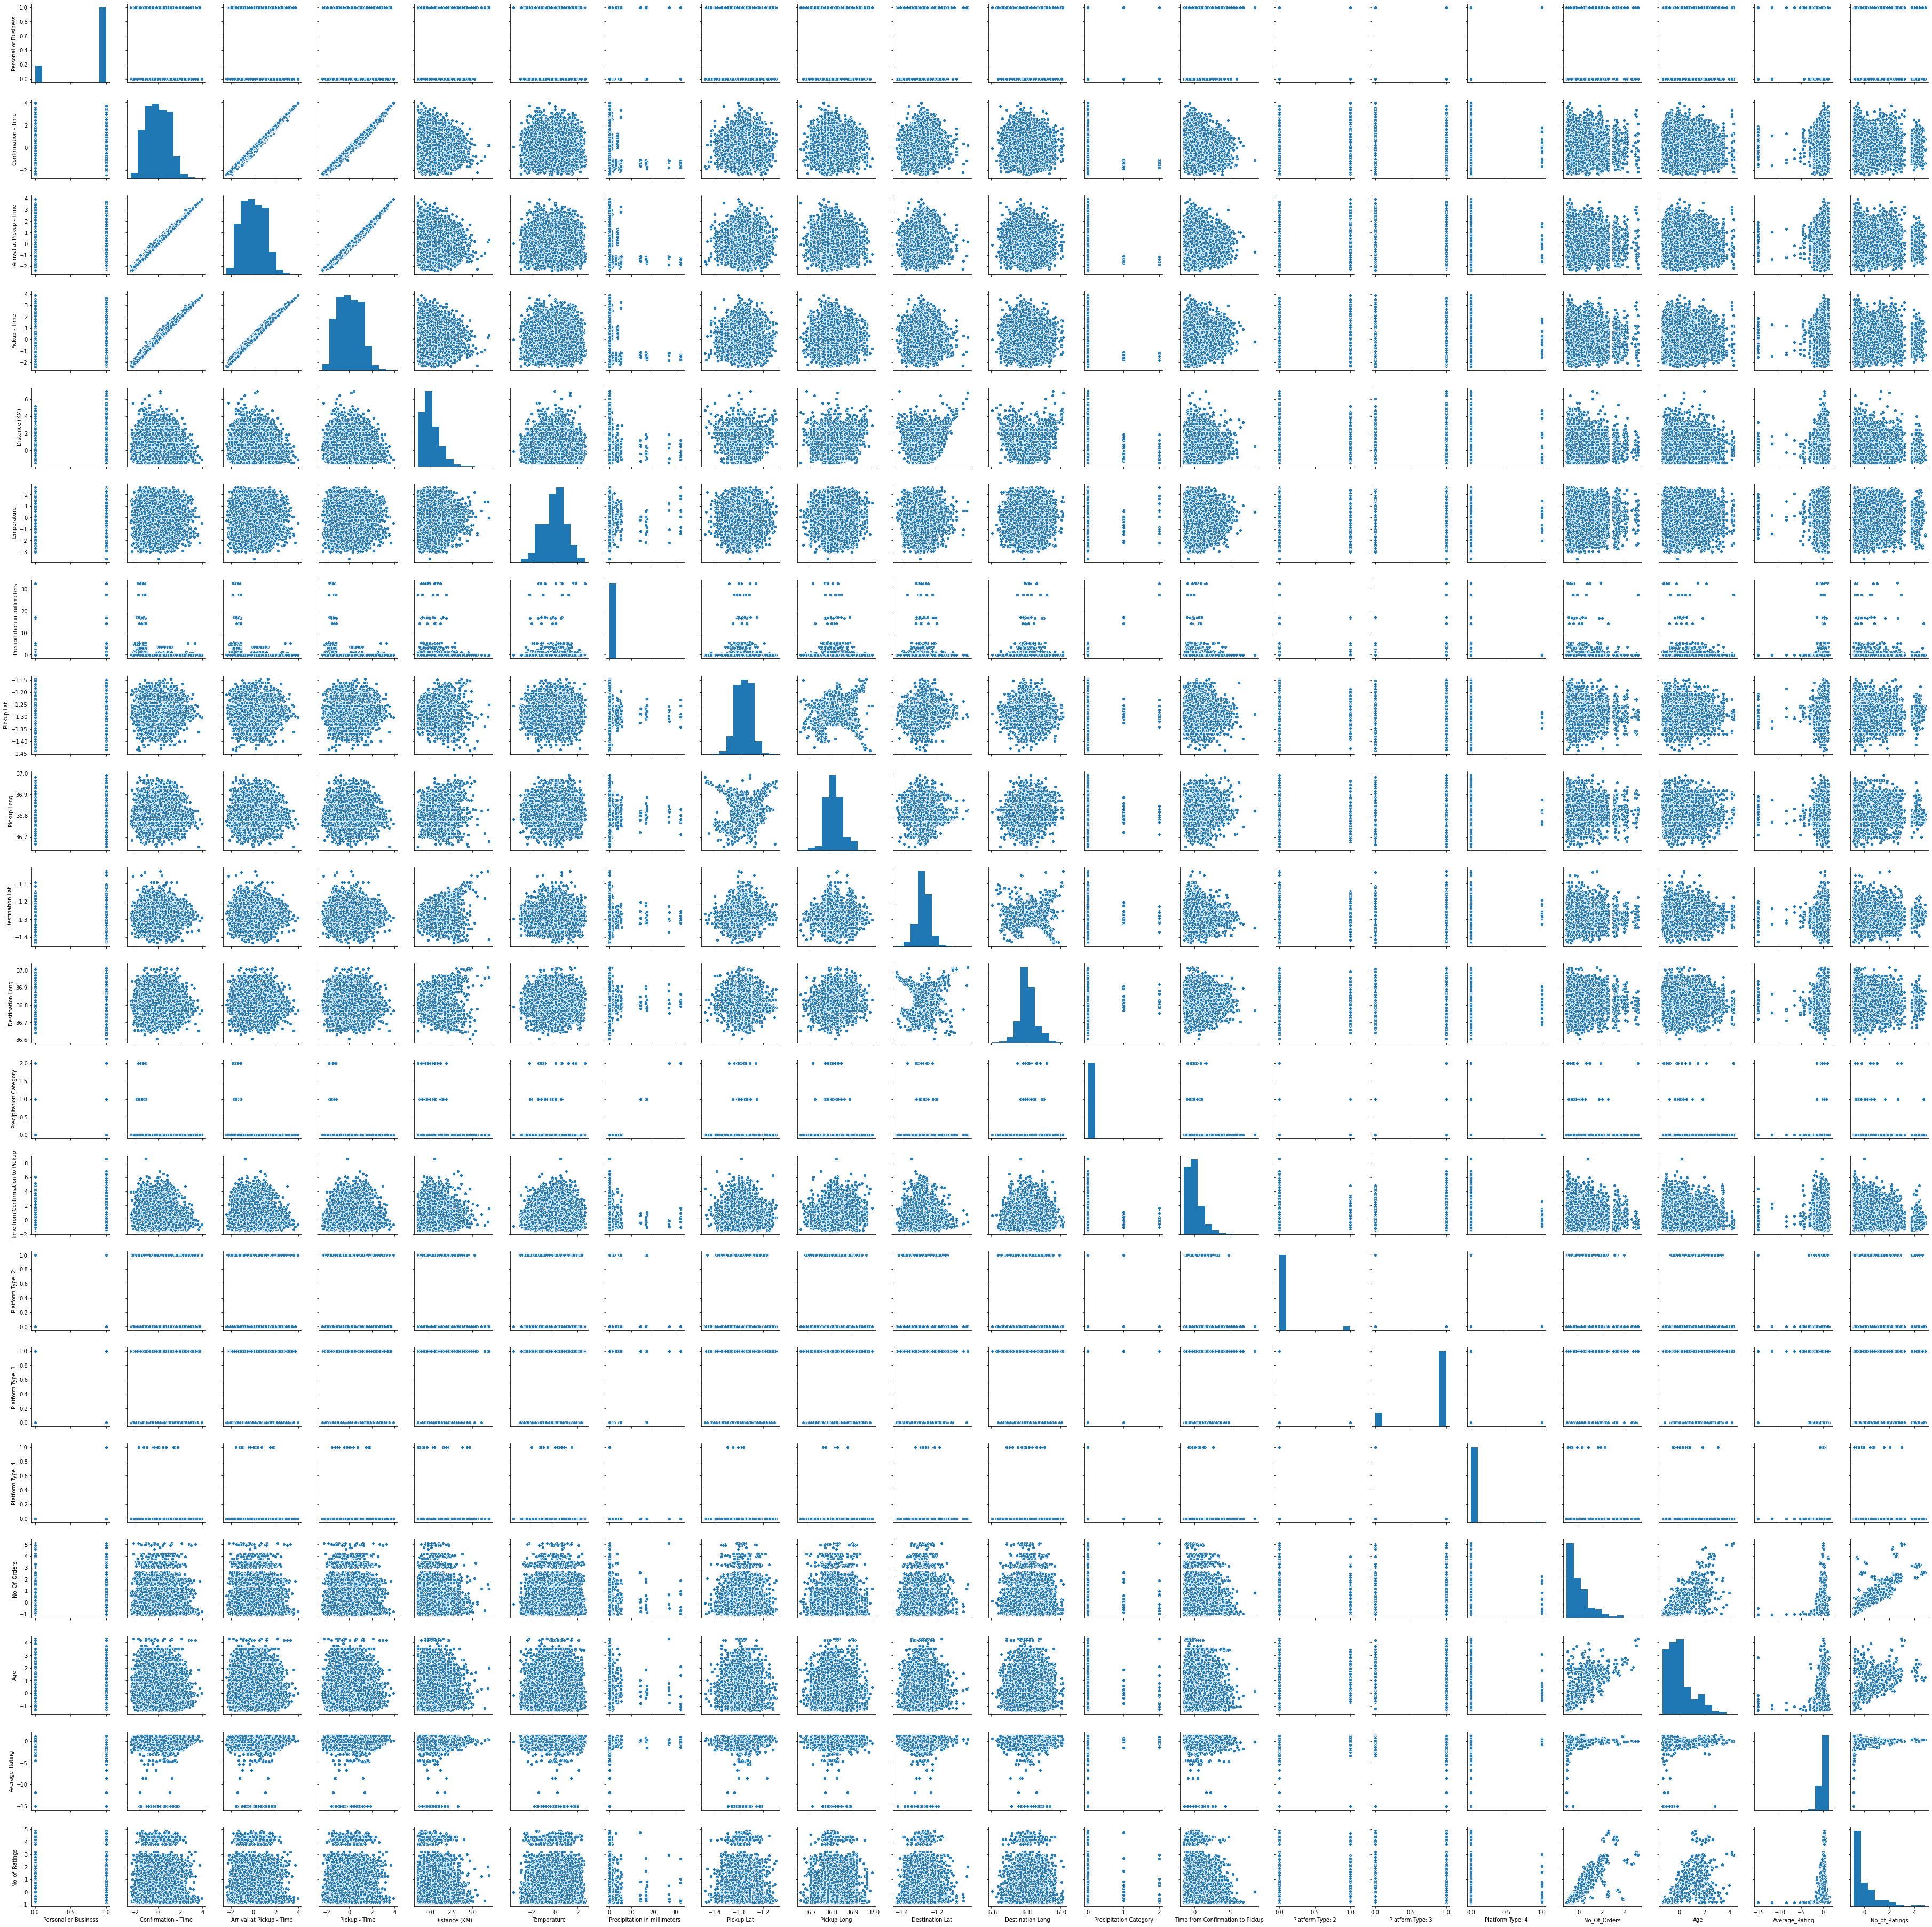

In [0]:
#@title Train Data Pair-Plots
import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(train_x[train_x['Arrival at Pickup - Time']>=-5])
plt.show()

In [0]:
#@title Check and remove midnight order


In [0]:
data1 = train_x[train_x['Arrival at Pickup - Time']<-5]
data = sc.inverse_transform(data1[columns_to_scale])
outliers = pd.DataFrame(data=data, columns = columns_to_scale, index=data1['Order No']).index
list(outliers.values)

original = train_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/EDSA/2 Machine Learning/1 Regression/4 Predict/Data Original/Train.csv')

original[original['Order No'] == list(outliers.values)[0]]



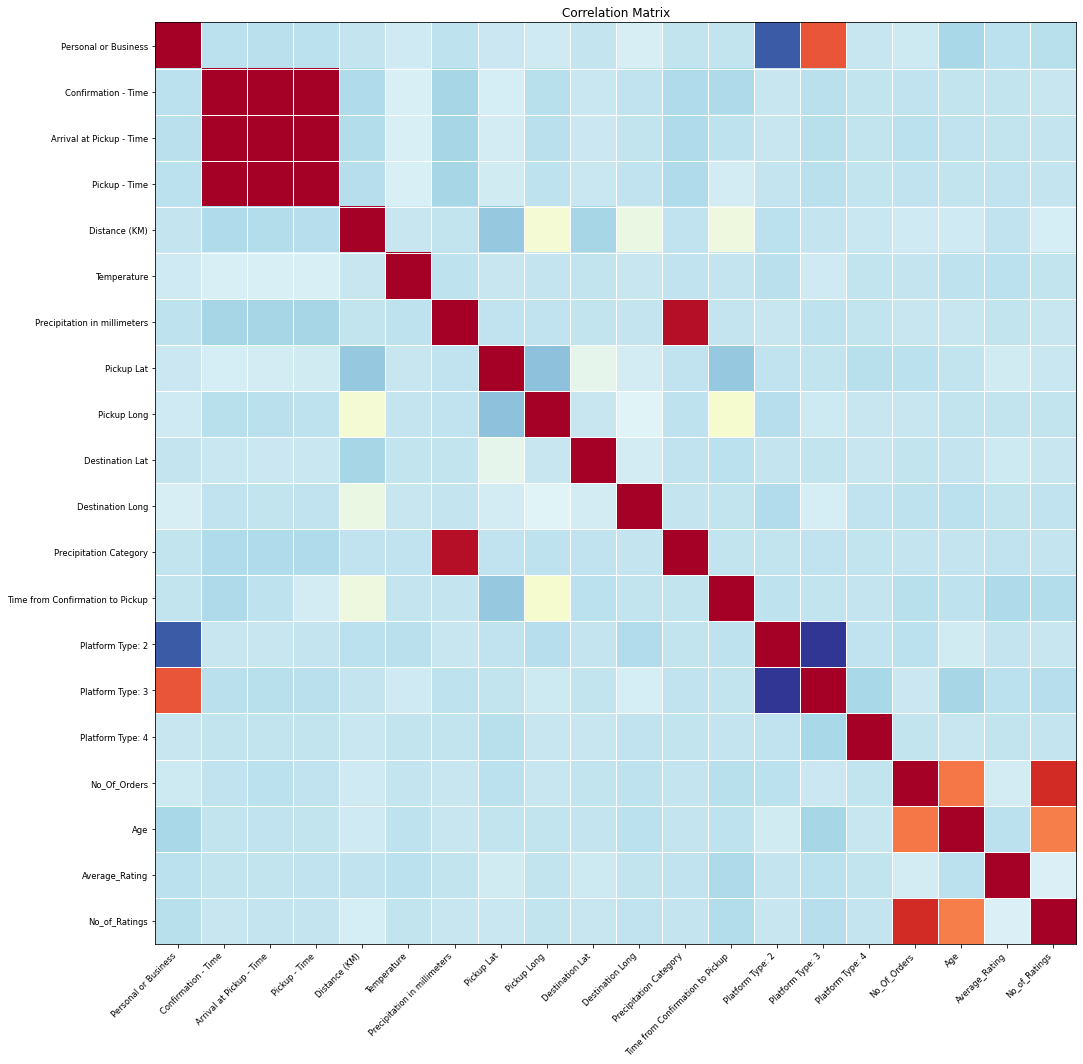

In [0]:
#@title Train Data Correlation plots
from statsmodels.graphics.correlation import plot_corr

fig = plt.figure(figsize=(15,15));
ax = fig.add_subplot(111);
plot_corr(train_x.corr(), xnames = train_x.corr().columns, ax = ax);

In [0]:
train_data['Confirmation - Time']<=-4

27     True
739    True
851    True
806    True
159    True
       ... 
712    True
851    True
642    True
41     True
801    True
Name: Confirmation - Time, Length: 21199, dtype: bool

# Check linearity with response variable

- 